In [30]:
#ADDITIONAL DEPENDENCIES
# !pip install triangle
# !pip install rasterio
# !pip install geopy
# !pip install osmnx

In [1]:
import sys
import os
sys.path.append(r'C:\repos\snkit\src')
sys.path.append(r'C:\repos')
sys.path.append(r'C:\repos\ra2ce')
sys.path.append(r'C:\repos\ra2ce_multi_network')
from ci_adapt_utilities import *
from ci_adapt_classes import *
from ra2ce_multi_network.simplify_rail import *
from ra2ce_multi_network.simplify_rail import _merge_edges, _network_to_nx
import networkx as nx
import pandas as pd
from shapely import wkt, box, is_valid, make_valid
import re
from math import ceil
import ast


In [2]:
# Load configuration with ini file (created running config.py)
config_file=r'C:\repos\ci_adapt\config_ci_adapt.ini'
config = configparser.ConfigParser()
config.read(config_file)

# Set paths and data sources
p = Path('..')
hazard_type = config.get('DEFAULT', 'hazard_type')
infra_type = config.get('DEFAULT', 'infra_type')
country_code = config.get('DEFAULT', 'country_code')
country_name = config.get('DEFAULT', 'country_name')
hazard_data_subfolders = config.get('DEFAULT', 'hazard_data_subfolders')
asset_data = config.get('DEFAULT', 'asset_data')
vulnerability_data = config.get('DEFAULT', 'vulnerability_data')
data_path = Path(pathlib.Path.home().parts[0]) / 'Data'
interim_data_path = data_path / 'interim' / 'indirect_damages'

# MIRACA color scheme
color_string = config.get('DEFAULT', 'miraca_colors')
miraca_colors = ast.literal_eval(color_string)

In [51]:
#FUNCTION DEFINITIONS

# Assign a weight to each edge based on the length of the edge
def set_edge_weights(assets, graph):
    # Create a dictionary to store the length of each asset
    asset_lengths = {str(asset['osm_id']): asset['geometry'].length for asset_id, asset in assets.iterrows()}

    # Loop through the edges and assign the length of the asset to the edge
    for u, v, attr in graph.edges(data=True):
        if 'source_sink' in str(u) or 'source_sink' in str(v):
            continue

        # Initialize the weight and length of the edge
        attr['weight'] = int(0)
        attr['length'] = 0
        if 'osm_id' not in attr:
            continue
        
        # For concatenated edges, split the osm_id string and sum the lengths for each asset
        osm_ids = attr['osm_id'].split('; ')
        for osm_id in osm_ids:
            if osm_id in asset_lengths:
                attr['length'] += asset_lengths[osm_id]
                attr['weight'] += int(round(asset_lengths[osm_id]*1e3,0))

    return graph

def _create_terminal_graph(graph):
    # Make a copy of the graph with only the nodes identified as possible terminals
    terminal_graph = graph.copy()
    for u, attr in graph.nodes(data=True):
        if 'possible_terminal' not in graph.nodes[u]:
            continue
        if attr['possible_terminal'] == 0: 
            terminal_graph.remove_node(u)
    print('Possible terminals:', terminal_graph.number_of_nodes())
    
    return terminal_graph

def shortest_paths_between_terminals(graph, route_data):
    # Make a copy of the graph with only the nodes identified as possible terminals
    terminal_graph = _create_terminal_graph(graph)

    # Create a dictionary to store the shortest path between each OD pair
    paths={}

    # Iterate over all route ODs pairs and find the shortest path between the two nodes
    for _, attr in route_data.iterrows():

        # Snap route origin and destination geometries to nearest terminal node on graph
        if attr['geometry_from'].geom_type == 'Point':
            centroid_from = attr['geometry_from']
        else:
            centroid_from = attr['geometry_from'].centroid
        from_nearest_node = nearest_nodes(terminal_graph, centroid_from, 1)
        if attr['geometry_to'].geom_type == 'Point':
            centroid_to = attr['geometry_to']
        else:
            centroid_to = attr['geometry_to'].centroid
        to_nearest_node = nearest_nodes(terminal_graph, centroid_to, 1)

        # If the nearest nodes are the same for the origin and destination, skip the route
        if from_nearest_node[0][0] == to_nearest_node[0][0]:
            continue

        # Find the shortest path between the two terminals and the average flow on the path
        try:
            shortest_path = nx.shortest_path(graph, from_nearest_node[0][0], to_nearest_node[0][0], weight='weight')
            paths[(from_nearest_node[0][0], to_nearest_node[0][0])] = (shortest_path, int(ceil(attr['goods']/52)))
                
        except nx.NetworkXNoPath:
            print(f'No path between {from_nearest_node[0][0]} and {to_nearest_node[0][0]}')
            continue               

    return paths

def set_edge_capacities(graph, route_data, simplified=False):
    

    # Find shortest paths between each OD pair
    paths=shortest_paths_between_terminals(graph, route_data)
    
    if simplified==True:
        for _,_, attr in graph.edges(data=True):
            if 'capacity' not in attr:
                attr['capacity'] = 1
        
        return graph, paths

    # Assign capacity to edges that are part of a shortest path
    for (_,_), (nodes_in_path,average_flow) in paths.items():
        for i in range(len(nodes_in_path)-1):
            if not graph.has_edge(nodes_in_path[i], nodes_in_path[i+1], 0):
                continue
            if nodes_in_path[i]=='source_sink' or nodes_in_path[i+1]=='source_sink':
                continue 
            if 'capacity' in graph[nodes_in_path[i]][nodes_in_path[i+1]][0]:
                graph[nodes_in_path[i]][nodes_in_path[i+1]][0]['capacity'] = max(graph[nodes_in_path[i]][nodes_in_path[i+1]][0]['capacity'],2*average_flow)
            else:
                graph[nodes_in_path[i]][nodes_in_path[i+1]][0]['capacity'] = 2*average_flow
    
    # Set the capacity of edges that are not on a shortest path to the median capacity
    caps=[attr['capacity'] for _, _, attr in graph.edges(data=True) if 'capacity' in attr]
    
    median_cap = int(np.median(caps))

    for _,_, attr in graph.edges(data=True):
        if 'capacity' not in attr:
            attr['capacity'] = median_cap
        
    return graph, paths

# Function to find the nearest node in a graph to a point
def nearest_nodes(graph, point, n):
    near_nodes = []
    for node, attr in graph.nodes(data=True):
        if 'geometry' in attr:
            distance = point.distance(attr['geometry'])
            near_nodes.append((node, distance))
    
    near_nodes = sorted(near_nodes, key=lambda x: x[1])

    return near_nodes[:n]

# Function to set the demand of each node based on the OD data
def set_node_demand(od_data, graph):
    # make a copy of the graph with only the nodes where possible_terminal is 1
    terminal_graph = graph.copy()
    for u, attr in graph.nodes(data=True):
        if attr['possible_terminal'] == 0: 
            terminal_graph.remove_node(u)

    # Loop through od_data and assign demand to the nearest terminal node
    for od in od_data.iterrows():
        if od[1]['geometry'].geom_type == 'Point':
            centroid = od[1]['geometry']
        else:
            centroid = od[1]['geometry'].centroid
        
        nearest_node = nearest_nodes(terminal_graph, centroid, 1)
        graph.nodes[nearest_node[0][0]]['demand'] += int(ceil((od[1]['demand']-od[1]['supply'])/52))
        
    return graph

# Function to make the net demand of the graph equal to zero (condition for minimum cost flow algorithm)
def equalize_demand_supply(graph):
    sumdem=0 
    # Calculate the total demand
    for u,attr in graph.nodes(data=True):
        if attr['demand'] !=0:
            sumdem+=int(attr['demand'])

    # Add a source_sink node with demand equal to negative the total demand, to make the demand and supply equal
    graph.add_node('source_sink', demand=int(-sumdem), pos=graph.nodes[0]['pos'])

    # Add edges from all nodes to the source_sink node
    for u, attr in graph.nodes(data=True):
        if u == 'source_sink':
            continue
        if not graph.has_edge(u, 'source_sink', 0):
            graph.add_edge(u,'source_sink', 0, weight=int(1e10))
        if not graph.has_edge('source_sink', u):
            graph.add_edge('source_sink', u, 0, weight=int(1e10))

    return graph

#Source: SA
def create_virtual_graph(graph):
    max_weight_graph = max(attr['weight'] for _, _, attr in G.edges(data=True))
    print('Max weight: '+str(max_weight_graph))
    max_capacity_graph = max(attr['capacity'] for _, _, attr in G.edges(data=True))
    print('Max capacity: '+str(max_capacity_graph))

    # create a virtual node with dummy nodes
    graph_v=graph.copy()
    # convert to int
    for u, v, key, attr in G.edges(keys=True, data=True):
        graph_v.add_edge((str(u) + '_d'), (str(v) + '_d'), **attr)

    for u in G.nodes:
        graph_v.add_edge(u,(str(u) + '_d'),capacity=max_capacity_graph*100,weight=int(round(1e10,0)))
        graph_v.add_edge((str(u) + '_d'),u,capacity=max_capacity_graph*100,weight=0)

    # verify capacities, weights and demands are integers
    edge_capacities_types, edge_weights_types, node_demands_types = inspect_graph(graph_v)
    print("Edge Capacities Types:", set(edge_capacities_types))
    print("Edge Weights Types:", set(edge_weights_types))
    print("Node Demands Types:", set(node_demands_types))
    if {type(int())} == set(list(edge_capacities_types) + list(edge_weights_types) + list(node_demands_types)):
        print('Success: only int type values')
    else: 
        print('Warning! Not all values are integers')

    return graph_v

# Function to intersect the assets with hazard polygons
def process_hazard_indirect(single_footprint, assets, geom_dict):
    hazard_name = single_footprint.parts[-1].split('.')[0]
    # load hazard map
    hazard_map = ds.read_flood_map(single_footprint)


    # convert hazard data to epsg 3857
    if '.shp' or '.geojson' in str(hazard_map):
        hazard_map=gpd.read_file(hazard_map).to_crs(3857)[['geometry']] #take only necessary columns (geometry)
    else:
        hazard_map = gpd.GeoDataFrame(hazard_map).set_crs(4326).to_crs(3857)

    # make geometries valid
    hazard_map['geometry'] = hazard_map['geometry'].apply(lambda x: make_valid(x) if not is_valid(x) else x)

    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f'{timestamp} - Coarse overlay of hazard map with assets...')

    # coarse overlay of hazard map with assets (filter out assets that do not overlay with hazard map)
    intersected_assets=ds.overlay_hazard_assets(hazard_map,assets)
    overlay_assets = pd.DataFrame(intersected_assets.T,columns=['asset','hazard_point'])

    # numpify hazard map
    hazard_numpified = hazard_map.to_numpy() #.drop('w_depth_u', axis=1).to_numpy()
    disrupted_asset_length = {}
    # loop through assets in the same area as hazard map and get damage per asset
    for asset in tqdm(overlay_assets.groupby('asset'),total=len(overlay_assets.asset.unique())): #group asset items for different hazard points per asset and get total number of unique assets
        # retrieve asset geometry and do fine overlay
        asset_geom = geom_dict[asset[0]]              

        # find the exact hazard overlays:
        get_hazard_points = hazard_numpified[asset[1]['hazard_point'].values] 
        get_hazard_points[shapely.intersects(get_hazard_points[0][0],asset_geom)]

        # estimate damage
        if len(get_hazard_points) == 0: # no overlay of asset with hazard
            print('length of get_hazard_points is 0')       

        else:
            if asset_geom.geom_type == 'LineString':
                overlay_meters = shapely.length(shapely.intersection(get_hazard_points[0][0],asset_geom)) # get the length of exposed meters per hazard cell
                disrupted_asset_length[asset[0]]=np.sum(overlay_meters) # sum the total length of exposed meters

    return disrupted_asset_length

def calculate_new_paths(graph0, shortest_paths, disrupted_edges):
    graph=graph0.copy()
    for u,v in set(disrupted_edges):
        graph.remove_edge(u,v,0)
        
    disrupted_shortest_paths={}
    for (origin,destination), (nodes_in_spath,demand) in shortest_paths.items():
        edges_in_spath=[(nodes_in_spath[i],nodes_in_spath[i+1]) for i in range(len(nodes_in_spath)-1)]
        if set(disrupted_edges).isdisjoint(edges_in_spath):
            continue
        else:
            try:
                disrupted_shortest_paths[(origin,destination)] = (nx.shortest_path(graph, origin, destination, weight='weight'), demand)
            except nx.NetworkXNoPath:
                print(f'No path between {origin} and {destination}. Cannot ship by train.')
                disrupted_shortest_paths[(origin,destination)] = (None, demand)
                continue
    
    return disrupted_shortest_paths

def calculate_economic_impact_shortest_paths(graph, shortest_paths, disrupted_shortest_paths, average_train_load_tons, average_train_cost_per_ton_km, average_road_cost_per_ton_km):
    # Initialize the economic impact variable
    economic_impact = 0
    # Loop through the edges where there is a change in flow
    for (origin, destination), (nodes_in_path, demand) in disrupted_shortest_paths.items():
        length_old_path=0
        for i in range(len(shortest_paths[(origin, destination)][0])-1):
            length_old_path += graph.edges[shortest_paths[(origin, destination)][0][i], shortest_paths[(origin, destination)][0][i+1], 0]['length']/1000
                     
        if (nodes_in_path is None) or ('_d' in str(nodes_in_path)):
            economic_impact += demand*average_train_load_tons*(average_road_cost_per_ton_km-average_train_cost_per_ton_km)*length_old_path
            continue


        else:
            length_new_path=0
            for i in range(len(nodes_in_path)-1):
                length_new_path += graph.edges[nodes_in_path[i], nodes_in_path[i+1], 0]['length']/1000
            economic_impact += demand*average_train_load_tons*average_train_cost_per_ton_km*(length_new_path-length_old_path)
        

    return economic_impact

def inspect_graph(graph):
    edge_capacities_types = []
    edge_weights_types = []
    node_demands_types = []

    for _, _, attr in graph.edges(data=True):
        if 'capacity' in attr:
            edge_capacities_types.append(type(attr['capacity']))
        if 'weight' in attr:
            edge_weights_types.append(type(attr['weight']))

    for _, attr in graph.nodes(data=True):
        if 'demand' in attr:
            node_demands_types.append(type(attr['demand']))

    return edge_capacities_types, edge_weights_types, node_demands_types


In [4]:
# Read exposure data (OSM, OpenStreetMap contributors (2024) / osm-flex)
assets_path = data_path / asset_data
assets = gpd.read_file(assets_path)
assets = gpd.GeoDataFrame(assets).set_crs(4326).to_crs(3857)
print(f"{len(assets)} assets loaded.")


39783 assets loaded.


In [5]:
# Filter assets to only include railways
assets = assets.loc[assets.geometry.geom_type == 'LineString']
assets = assets.rename(columns={'railway' : 'asset'})
assets = assets[assets['asset']=='rail']
assets = assets[assets['railway:traffic_mode']!='"passenger"']
assets = assets.reset_index(drop=True)
print(f"{len(assets)} railway freight assets found.")

# Add buffer to assets to do area intersect and create dictionaries for quicker lookup
buffered_assets = ds.buffer_assets(assets)
geom_dict = assets['geometry'].to_dict()
type_dict = assets['asset'].to_dict()



34218 railway freight assets found.


In [6]:
from shapely.geometry import LineString
# Round coordinates to 0 decimal places to avoid GEOSException: TopologyException: side location conflict at x, y
def round_coordinates(line):
    rounded_coords = []
    for coord in line.coords:
        rounded_coords.append((round(coord[0], 0), round(coord[1], 0)))
    return LineString(rounded_coords)

geoms=[]
for geom in assets['geometry']:
    geoms.append(round_coordinates(geom))

assets['geometry']=geoms

In [7]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    #Source: Asgarpour/snkit
    # Create a railway networks with possible terminal nodes. This returns a complex network, as includes the rail tracks with the highest level of detail.
    aggregation_range = 0.08 # in km
    complex_rail_network = get_rail_network_with_terminals(network_gdf=assets, aggregation_range=aggregation_range)


In [8]:
with warnings.catch_warnings():
    try:
        warnings.simplefilter("ignore")
        merged_rail_network = merge_edges(network=complex_rail_network, excluded_edge_types=['bridge', 'tunnel']) #Must add network= to pass excluded_edge_types as a keyword argument

        # Number of nodes and edges reduced
        print(f"Difference in node counts: {complex_rail_network.nodes.shape[0] - merged_rail_network.nodes.shape[0]}")
        print(f"Difference in node counts %: {round(100*(complex_rail_network.nodes.shape[0] - merged_rail_network.nodes.shape[0])/complex_rail_network.nodes.shape[0], 0)}")
        print(f"Difference in edge counts: {complex_rail_network.edges.shape[0] - merged_rail_network.edges.shape[0]}")
        print(f"Difference in edge counts %: {round(100*(complex_rail_network.edges.shape[0] - merged_rail_network.edges.shape[0])/complex_rail_network.edges.shape[0], 0)}")
    except Exception as e:
        print(f'Exception: {e}')
        print('Skipping simplification step.')
        merged_rail_network=complex_rail_network
    

Difference in node counts: 7400
Difference in node counts %: 19.0
Difference in edge counts: 7514
Difference in edge counts %: 17.0


In [9]:
merged_rail_graph = _network_to_nx(merged_rail_network)

G=nx.MultiDiGraph(merged_rail_graph)

# Initialise demand and give position to nodes
for _, attr in G.nodes(data=True):
    attr['demand'] = int(0)
    attr['pos'] = (attr['geometry'].x, attr['geometry'].y)

In [10]:
# Set weights for flow model
G = set_edge_weights(assets, G)


In [48]:
from pyproj import Transformer
from shapely.geometry import Point
transformer=Transformer.from_crs("EPSG:4326", "EPSG:3857")

# Load route data
route_data_source=r'C:\Data\traffic\NET_SEGMENTS_EU_EFTA_Filtered_0.xlsx'
route_data = pd.read_excel(route_data_source)

# Only keep columns that are necessary: From_Latitude, From_Longitude, To_Latitude, To_Longitude, Number_Goods_trains, Country
route_data = route_data[['From', 'To', 'From_Latitude', 'From_Longitude', 'To_Latitude', 'To_Longitude', 'Number_Goods_trains', 'Country']]

# Rename columns Number_Goods_trains to goods 
route_data = route_data.rename(columns={'Number_Goods_trains' : 'goods'})

# Drop rows with no goods
route_data = route_data[route_data['goods'] > 0]

# Drop rows that are not from Country "DE"
route_data = route_data[route_data['Country'] == 'DE']

# Convert From_Latitude, From_Longitude and To_Latitude, To_Longitude to geometries
route_data['geometry_from'] = route_data.apply(lambda k: Point(k['From_Longitude'], k['From_Latitude']), axis=1)
route_data['geometry_to'] = route_data.apply(lambda k: Point(k['To_Longitude'], k['To_Latitude']), axis=1)


# Filter route data to only include routes that are within the bounds of the assets
assets_bounds=assets.copy().to_crs(4326).total_bounds
route_data = route_data[route_data['geometry_from'].apply(lambda geom: box(*assets_bounds).contains(geom))]
route_data = route_data[route_data['geometry_to'].apply(lambda geom: box(*assets_bounds).contains(geom))]

# # Reproject geometries of points from 4326 to 3857
# route_data['geometry_from'] = route_data['geometry_from'].apply(lambda k: Point(transformer.transform(k.x, k.y)))
# route_data['geometry_to'] = route_data['geometry_to'].apply(lambda k: Point(transformer.transform(k.x, k.y)))
# Reproject geometries of points from 4326 to 3857
route_data['geometry_from'] = route_data['geometry_from'].apply(lambda k: Point(transformer.transform(k.y, k.x)))
route_data['geometry_to'] = route_data['geometry_to'].apply(lambda k: Point(transformer.transform(k.y, k.x)))



In [49]:
route_data.head(3)

,From,To,From_Latitude,From_Longitude,To_Latitude,To_Longitude,goods,Country,geometry_from,geometry_to
3185,Köln Hbf,Köln-Ehrenfeld Pbf,50.944122,6.960036,50.952471,6.925596,1.0,DE,POINT (774787.7024959939 6611415.535985327),POINT (770953.8479898049 6612890.651068159)
3188,Wemmetsweiler Kurve Einmündung,Wemmetsweiler Kurve,49.367432,7.067455,49.364374,7.070906,1.0,DE,POINT (786745.4918043753 6337438.538431248),POINT (787129.6553671028 6336915.808943185)
3189,Wörth (Rhein),Berg (Pfalz) Grenze,49.046749,8.274034,48.976282,8.196315,1.0,DE,POINT (921061.2021490593 6282797.482770083),POINT (912409.6633882357 6270837.889888476)


In [21]:
# Create a table with the unique origins or destinations from the route data
unique_origins = route_data[['From' ,'geometry_from']].drop_duplicates().reset_index(drop=True)
unique_destinations = route_data[['To' ,'geometry_to']].drop_duplicates().reset_index(drop=True)

# Combine the unique origins and destinations to create a table with all possible terminals and drop duplicates
terminals = pd.concat([unique_origins.rename(columns={'From' : 'terminal', 'geometry_from' : 'geometry'}), unique_destinations.rename(columns={'To' : 'terminal', 'geometry_to' : 'geometry'})]).drop_duplicates().reset_index(drop=True)   

terminals_gdf=gpd.GeoDataFrame(terminals, geometry='geometry').set_crs(3857).to_crs(4326)
terminals_gdf.head(3)

,terminal,geometry
0,Köln Hbf,POINT (50.94412 6.96004)
1,Wemmetsweiler Kurve Einmündung,POINT (49.36743 7.06746)
2,Wörth (Rhein),POINT (49.04675 8.27403)


In [48]:
# load G and shortest paths
if os.path.exists(interim_data_path / 'G.pkl'):
    G = pickle.load(open(interim_data_path / 'G.pkl','rb'))
    shortest_paths = pickle.load(open(interim_data_path / 'shortest_paths.pkl', 'rb'))
    disrupted_edges_by_basin = pickle.load(open(interim_data_path / 'disrupted_edges_by_basin.pkl', 'rb'))
    disrupted_shortest_paths = pickle.load(open(interim_data_path / 'disrupted_shortest_paths.pkl', 'rb'))
    # economic_impact = pickle.load(open(interim_data_path / 'economic_impact.pkl', 'rb'))
    # economic_impact_shortest_paths = pickle.load(open(interim_data_path / 'economic_impact_shortest_paths.pkl', 'rb'))
    print('Data loaded from pickle files.')

In [52]:
# Set capacities for flow model
G, shortest_paths = set_edge_capacities(G, route_data, simplified=True)


Possible terminals: 2106
No path between 29095 and 29081
No path between 18455 and 26270
No path between 26270 and 18455
No path between 35082 and 30180
No path between 29081 and 29095
No path between 29367 and 30458
No path between 30180 and 35082
No path between 30458 and 29367
No path between 34825 and 35070
No path between 37903 and 26955
No path between 26955 and 37903
No path between 24704 and 32257
No path between 24704 and 32257
No path between 17858 and 33474
No path between 31537 and 38170
No path between 33474 and 17858
No path between 37276 and 17858
No path between 17858 and 37276
No path between 38170 and 31537
No path between 32671 and 28909
No path between 28909 and 32671
No path between 34387 and 19040
No path between 19040 and 34387
No path between 28555 and 28909
No path between 11814 and 9630
No path between 28909 and 28072
No path between 9630 and 11814
No path between 28072 and 28909
No path between 28909 and 28555
No path between 35070 and 34825
No path between 3

In [54]:
# Create initial virtual graph
G_v0=create_virtual_graph(G)


Max weight: 43394271
Max capacity: 1
Edge Capacities Types: {<class 'int'>}
Edge Weights Types: {<class 'int'>}
Node Demands Types: {<class 'int'>}
Success: only int type values


In [55]:
G_v=G_v0.copy()

In [56]:
# Define the baseline return periods 
"""
Return period definitions for Rhineland Palatinate (DERP) based on the report by Rauthe M, et al. (2020):
_H_=10-25y 
_M_=100y
_L_=200y
"""
return_period_dict = {'_H_': 10,'_M_': 100,'_L_': 200}

# Add climate change: calculate the dynamic return periods based on flat increase factors. 
# This value has been catchment-specific with frequency increasing in some regions and decreasing in others. 
# It is reasonable that in the future, the frequency will continue to change differently by catchment.

increase_factor = {
    '_H_': 2,
    '_M_': 6.6,
    '_L_': 9.1
} # https://hess.copernicus.org/preprints/hess-2016-65/hess-2016-65-manuscript-version2.pdf 


num_years = 100
return_periods = calculate_dynamic_return_periods(return_period_dict, num_years, increase_factor)
return_periods

{'_H_': [10.0,
  9.900990099009901,
  9.80392156862745,
  9.70873786407767,
  9.615384615384615,
  9.523809523809524,
  9.433962264150942,
  9.345794392523363,
  9.259259259259258,
  9.174311926605503,
  9.090909090909092,
  9.00900900900901,
  8.928571428571429,
  8.849557522123893,
  8.771929824561402,
  8.695652173913043,
  8.620689655172413,
  8.547008547008547,
  8.47457627118644,
  8.403361344537814,
  8.333333333333332,
  8.264462809917354,
  8.19672131147541,
  8.130081300813009,
  8.064516129032258,
  8.0,
  7.936507936507937,
  7.874015748031496,
  7.8125,
  7.751937984496124,
  7.692307692307692,
  7.633587786259541,
  7.575757575757575,
  7.518796992481203,
  7.462686567164178,
  7.4074074074074066,
  7.352941176470588,
  7.2992700729927,
  7.246376811594202,
  7.194244604316546,
  7.142857142857142,
  7.092198581560283,
  7.04225352112676,
  6.9930069930069925,
  6.944444444444444,
  6.896551724137931,
  6.84931506849315,
  6.802721088435373,
  6.756756756756756,
  6.71140

In [57]:
if 'collect_output' not in locals():
    collect_output_path = f'C:/Data/interim/collected_flood_runs/sample_collected_run.pkl'
    with open(collect_output_path, 'rb') as f:
        collect_output = pickle.load(f)

In [58]:
# Define costs for different transport modes
average_train_load_tons = (896+1344+2160+1344+896+896+1344+1512+896+390)/10 # in Tons per train. Source: Kennisinstituut voor Mobiliteitsbeleid. 2023. Cost Figures for Freight Transport – final report
average_train_cost_per_ton_km = (0.014+0.018+0.047+0.045)/4 # in Euros per ton per km. Source: Kennisinstituut voor Mobiliteitsbeleid. 2023. Cost Figures for Freight Transport – final report
average_road_cost_per_ton_km = (0.395+0.375+0.246+0.203+0.138+0.153+0.125+0.103+0.122+0.099)/10 # in Euros per ton per km. Source: Kennisinstituut voor Mobiliteitsbeleid. 2023. Cost Figures for Freight Transport – final report

In [59]:
# Loop through the event files and calculate the economic impact of each event
disrupted_asset_lengths={}
disrupted_shortest_paths={}
event_impacts={}
disrupted_edges_by_basin={}

for hazard_map, asset_dict in collect_output.items():
    disrupted_assets = [key for key in asset_dict.keys()]
    disrupted_osm_ids = [
        assets.loc[asset_index]['osm_id'] 
        for asset_index in disrupted_assets 
        if asset_index in assets.index and (
            (assets.loc[asset_index]['bridge'] != 'yes') 
            and (assets.loc[asset_index]['tunnel'] != 'yes')
            and (assets.loc[asset_index]['osm_id'] is not None)
            )
        ]
    
    if len(disrupted_osm_ids)==0:
        continue

    disrupted_edges=[]
    
    for u,v,attr in G.edges(data=True):
        if 'osm_id' not in attr: 
            continue
        if attr['bridge']=='yes' or attr['tunnel']=='yes':
            continue
        matching_ids=[osm_id for osm_id in attr['osm_id'].split('; ') if osm_id in disrupted_osm_ids]
        if len(matching_ids)>0:
            disrupted_edges.append((u,v))
            
    print(f'Disrupted edges: {len(disrupted_edges)}')

    # If there are no disrupted edges in the event, move to next event
    if len(disrupted_edges)==0:
        continue
    
    disrupted_edges_by_basin[hazard_map]=disrupted_edges
    disrupted_shortest_paths[hazard_map]=calculate_new_paths(G_v0, shortest_paths, disrupted_edges)

    if disrupted_shortest_paths[hazard_map] == {}: # No disrupted paths, no economic impact
        print(f'No shortest paths disrupted for {hazard_map}. No economic impact.')
        continue


    print('Calculating economic impact...')
    impact=calculate_economic_impact_shortest_paths(G_v, shortest_paths, disrupted_shortest_paths[hazard_map], average_train_load_tons, average_train_cost_per_ton_km, average_road_cost_per_ton_km)
    event_impacts[hazard_map]=impact
    print(hazard_map, impact)

Disrupted edges: 24
No shortest paths disrupted for flood_DERP_RW_H_4326_2080430320. No economic impact.
Disrupted edges: 60
Calculating economic impact...
flood_DERP_RW_L_4326_2080430320 378730.42330957693
Disrupted edges: 52
Calculating economic impact...
flood_DERP_RW_M_4326_2080430320 378730.42330957693


In [60]:
event_impacts

{'flood_DERP_RW_L_4326_2080430320': 378730.42330957693,
 'flood_DERP_RW_M_4326_2080430320': 378730.42330957693}

In [61]:
files = [file for file in os.listdir('C:/Data/interim/collected_flood_runs') if file.endswith('.pkl') and file.startswith('overlay')]
basins_list=list(set([int(file.split('.')[0].split('_')[-1]) for file in files]))
basin_dict = {}
for basin in basins_list:
    basin_dict[basin] = {}
    for key in event_impacts.keys():
        if not str(basin) in key:
            continue
        if str(basin) in key:
            basin_dict[basin][key.split('_RW')[-1][0:3]] = event_impacts[key]


for rp in return_period_dict.keys():
    # add rp as a key to all nested dictionaries with 0 as a value if the rp is not already a key
    for basin in basin_dict.keys():
        if rp not in basin_dict[basin].keys():
            basin_dict[basin][rp] = 0

basin_dict
          

{2080430320: {'_L_': 378730.42330957693, '_M_': 378730.42330957693, '_H_': 0}}

In [62]:

aggregated_df_by_basin = {}
ead_by_ts_by_basin = {}

for basin, damage_dict in basin_dict.items():
    if len(damage_dict) == 0:
        continue

    aggregated_df_by_basin[basin] = pd.DataFrame.from_dict(damage_dict, orient='index', columns=['Total indirect damage'])
    aggregated_df_by_basin[basin]['Return Period'] = [return_periods[index] for index in aggregated_df_by_basin[basin].index]
    probabilities = [[1 / rp for rp in ts] for ts in aggregated_df_by_basin[basin]['Return Period']]
    aggregated_df_by_basin[basin]['Probability'] = probabilities
    dmgs = []

    for ts in range(len(probabilities[0])):    
        dmgs_m = []

        for rp in range(len(probabilities)-1):
            d_rp= probabilities[rp][ts] - probabilities[rp + 1][ts]
            trap_damage_m = 0.5 * (aggregated_df_by_basin[basin]['Total indirect damage'].iloc[rp] + aggregated_df_by_basin[basin]['Total indirect damage'].iloc[rp + 1])
            dmgs_m.append(d_rp * trap_damage_m)
        
        # Add the portion of damages corresponding to the tails of the distribution
        d0_rp = probabilities[-1][ts]
        damage_m0 = max(aggregated_df_by_basin[basin]['Total indirect damage'])
        dmgs_m.append(d0_rp * damage_m0)

        d_end_rp = (1/4)-probabilities[0][ts]
        damage_m_end = 0.5 * min(aggregated_df_by_basin[basin]['Total indirect damage'])

        dmgs_m.append(d_end_rp * damage_m_end)

        dmgs.append((sum(dmgs_m)))
    
    ead_by_ts_by_basin[basin] = pd.DataFrame(dmgs, columns=['Total indirect damage'])


In [63]:
# Find total damages by basin over the 100 y period
total_damages_by_basin = {basin: ead_by_ts_by_basin[basin].values.sum() for basin in ead_by_ts_by_basin.keys()}
total_damages_by_basin


{2080430320: 3107956.5362842157}

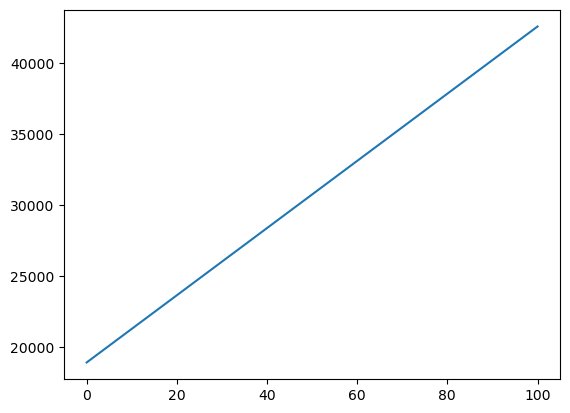

In [64]:
#plot the EAD for each basin    
from matplotlib import pyplot as plt
for basin, ead_df in ead_by_ts_by_basin.items():
    plt.plot(ead_df, label=basin)
        

In [65]:
import geopandas as gpd
from lonboard import viz  # Assuming 'lonboard' is a correct module name; if not, correct as necessary

def georeference_damages(gdf, damages):
    # Initialize 'damage' column to 0
    gdf['damage'] = 0
    # Vectorized operation to map damages based on 'HYBAS_ID'
    damage_map = {key: value for key, value in damages.items() if key in gdf['HYBAS_ID'].tolist()}
    gdf['damage'] = gdf['HYBAS_ID'].map(damage_map).fillna(0)
    return gdf

# Load basins GeoDataFrame
basins = gpd.read_file(r'c:\Data\Floods\basins\hybas_eu_lev01-12_v1c\hybas_eu_lev08_v1c_valid.shp')

# Assuming 'basins_list' is a predefined list of 'HYBAS_ID's to filter by
basins_filtered = basins[basins['HYBAS_ID'].isin(basins_list)]

# Assuming 'ead_df' is a dictionary with 'HYBAS_ID' as keys and damage values as values
ead_gdf = georeference_damages(basins_filtered, total_damages_by_basin)
ead_gdf


c:\Users\peregrin\AppData\Local\anaconda3\envs\ci_adapt_env\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,HYBAS_ID,NEXT_DOWN,NEXT_SINK,MAIN_BAS,DIST_SINK,DIST_MAIN,SUB_AREA,UP_AREA,PFAF_ID,ENDO,COAST,ORDER,SORT,geometry,damage
6378,2080430320,2080428500,2080023010,2080023010,511.4,511.4,64.9,4060.3,23263061,0,0,2,6379,"POLYGON ((7.91667 49.88750, 7.91424 49.88785, ...",3.107957e+06


In [66]:
# save G and shortest paths to pickle files
pickle.dump(G, open(interim_data_path / 'G.pkl', 'wb'))
pickle.dump(shortest_paths, open(interim_data_path / 'shortest_paths.pkl', 'wb'))
pickle.dump(disrupted_edges_by_basin, open(interim_data_path / 'disrupted_edges_by_basin.pkl', 'wb'))
pickle.dump(disrupted_shortest_paths, open(interim_data_path / 'disrupted_shortest_paths.pkl', 'wb'))
pickle.dump(event_impacts, open(interim_data_path / 'event_impacts.pkl', 'wb'))
pickle.dump(ead_gdf, open(interim_data_path / 'ead_gdf.pkl', 'wb'))
pickle.dump(ead_by_ts_by_basin, open(interim_data_path / 'ead_by_ts_by_basin.pkl', 'wb'))
print('Data saved to pickle files.')


Data saved to pickle files.


In [63]:
# Create visualisation for the basin and the discharge points
from lonboard import Map, PolygonLayer, PathLayer

layer_basin = PolygonLayer.from_geopandas(basins_filtered,
    get_fill_color=miraca_colors['grey_100'],
    get_line_color=miraca_colors['green_900'], get_line_width=100,
    auto_highlight=False,
    filled=False)

# Flood return period: H for frequent(RP10-20), M for 100 year return period (RP100) and L for extreme (RP2000)
return_period_str='L'
basin_vis_str='2080430320'
# Generate flood layers and protection layers for visualization
flood_plot_path=rf'C:\Data\Floods\Germany\basin_intersections\DERP_RW_L_4326_hybas_intersections\flood_DERP_RW_{return_period_str}_4326_{basin_vis_str}.geojson'
flood_m = data_path / flood_plot_path
flood_gdf=gpd.read_file(flood_m)
layers_flood=[]
f_area_colors = {1:'blue', 3:'green'}
for f_area in flood_gdf.flood_area.unique():
    for f_depth in flood_gdf.depth_class.unique():
        subset_gdf = flood_gdf[(flood_gdf.depth_class==f_depth) & (flood_gdf.flood_area==f_area)]
        if not subset_gdf.empty:
            color_key=f'{f_area_colors[f_area]}_{f_depth}00'
            layers_flood.append(PolygonLayer.from_geopandas(subset_gdf, 
                                                            get_fill_color=miraca_colors[color_key], 
                                                            opacity=0.5, 
                                                            stroked=False))

assets_no_buffer = assets.copy()
#drop the buffered geometry from the assets
assets_no_buffer = assets_no_buffer.drop(columns='buffered')
layer_rail = PathLayer.from_geopandas(assets_no_buffer, width_min_pixels=0.8)

layers=[]
if layer_basin is not None:
    layers.append(layer_basin)
else:
    print('No basin layer')
if layers_flood is not None:
    layers.extend(layers_flood)
else:
    print('No flood layers')
if layer_rail is not None:
    layers.append(layer_rail)
else:
    print('No rail layers')

Voyager = 'https://basemaps.cartocdn.com/gl/voyager-gl-style/style.json'

m = Map(layers, show_tooltip=True, basemap_style=Voyager) 

m


c:\Users\peregrin\AppData\Local\anaconda3\envs\ci_adapt_env\Lib\site-packages\lonboard\_geoarrow\ops\reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


Map(basemap_style='https://basemaps.cartocdn.com/gl/voyager-gl-style/style.json', layers=[PolygonLayer(filled=…

In [64]:
ead_gdf

,HYBAS_ID,NEXT_DOWN,NEXT_SINK,MAIN_BAS,DIST_SINK,DIST_MAIN,SUB_AREA,UP_AREA,PFAF_ID,ENDO,COAST,ORDER,SORT,geometry,damage
6378,2080430320,2080428500,2080023010,2080023010,511.4,511.4,64.9,4060.3,23263061,0,0,2,6379,"POLYGON ((7.91667 49.88750, 7.91424 49.88785, ...",2.450038e+06


In [31]:
# Visualisation

def get_node_from_spaths(shortest_paths):
    nodes_list = []
    for key in shortest_paths.keys():
        origin, destination = key
        nodes_list.append(origin)
        nodes_list.append(destination)

    nodes_list = list(set(nodes_list))  # Remove duplicates

    return nodes_list

def from_spaths_to_edges(shortest_paths):
    edges_in_paths = []
    for (o, d), (nodes_in_path, demand) in shortest_paths.items():
        if nodes_in_path is None:
            print(f'No path found between {o} and {d}. Cannot ship by train.')
            continue
        
        edges_in_path = [(nodes_in_path[i], nodes_in_path[i+1]) for i in range(len(nodes_in_path)-1)]
        edges_in_paths.extend(edges_in_path)
    return edges_in_paths




